plot facebook data in a 2D Histogramm

In [68]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
import utm
from utils import load_stops
from scipy import signal

In [130]:
# takes around 3mins repending on number of points


# read population
df = pd.read_csv("pop_ger.csv", sep = ",", names = ["x","y","weight"], skiprows = 1)

# read coordinates of stop
df_coordinates = load_stops("GER_Saxony_Leipzig")

minlat = df_coordinates["stop_lat"].min()
maxlat = df_coordinates["stop_lat"].max()
minlon = df_coordinates["stop_lon"].min()
maxlon = df_coordinates["stop_lon"].max()

# select rows that are inside of the bounding box
df = df[(df.x >= minlat) & (df.x <= maxlat)]
df = df[(df.y >= minlon) & (df.y <= maxlon)]

# convert to numpy
xlist = df["x"].tolist()
ylist = df["y"].tolist()
weight = df["weight"].tolist()

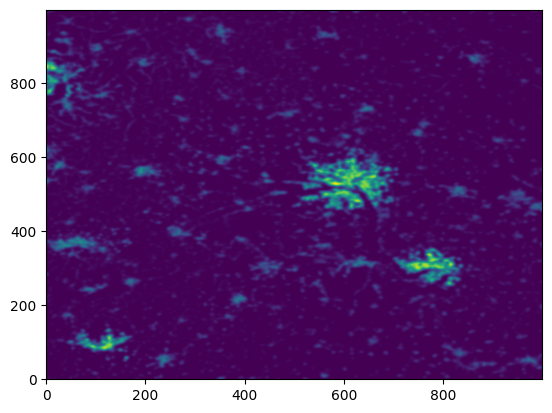

In [131]:
# plot population

BINS = 1000
BLUR = 3

fig, ax = plt.subplots()
data = np.histogram2d(xlist, ylist, weights = weight, bins=BINS)[0]
data = gaussian_filter(data, sigma=BLUR)
plt.pcolormesh(data.T, shading='gouraud')
fig.canvas.draw()

Relating everything back to how good each place is connected

Metrics:

- Stop Density
- "Mobility Score"

In [149]:

import math as m
import matplotlib.pyplot as plt
from sklearn import preprocessing

GRIDSIZE = 100
POPULATIONGRID = [[0 for i in range(GRIDSIZE)] for j in range (GRIDSIZE)]

def scale_number(unscaled, to_min, to_max, from_min, from_max):
    return (to_max-to_min)*(unscaled-from_min)/(from_max-from_min)+to_min

def scale_list(inlist, to_min = 0, to_max = GRIDSIZE):
    return [scale_number(i, to_min, to_max, min(inlist), max(intlist)) for i in inlist]

x_list_scaled = scale_list(xlist)

print(x_list_scaled[0:10])


# sanity check
TOTALPOP = np.sum(POPULATIONGRID)
print("Number of Inhabitants: ", TOTALPOP)

plt.imshow(POPULATIONGRID, interpolation = None, origin = "lower")
plt.show()

NameError: name 'inlistl' is not defined

Read in Neighbours and put them on the same grid

In [43]:
# calculate some stats
import math as m
import haversine as hs 

diagonal = hs.haversine((maxlat, maxlon), (minlat, minlon))
side = diagonal / m.sqrt(2)

# Maßstab berechnen
onepxlength = side / GRIDSIZE # length of one pixel in grid in KM

print("One Pixel in m:", onepxlength * 1000)
print("Square side Length in KM: ", side)

One Pixel in m: 55.715753764800866
Square side Length in KM:  111.43150752960173


[1272, 1140]


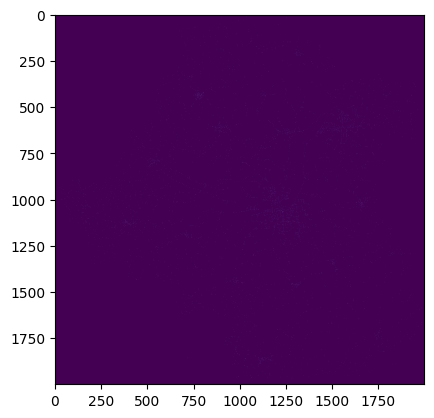

In [81]:
import json
from utils import load_stops_as_dict
from scipy.ndimage import gaussian_filter
from scipy.signal import convolve2d, fftconvolve
import numpy as np

id_list = df_coordinates["stop_id"].tolist()
latlist = df_coordinates["stop_lat"].tolist()
lonlist = df_coordinates["stop_lon"].tolist()

STOPSGRID = [[0 for i in range(GRIDSIZE)] for j in range (GRIDSIZE)] # create grid thats 0-99

for id, lat, lon in zip(id_list, latlist, lonlist):

    # convert directly to grid indices 
    xind, yind = getindices(lat, lon)

    # not all stops are inside of the bounding box created earlier
    if (0 <= yind < GRIDSIZE) and (0 <= xind < GRIDSIZE):
        STOPSGRID[yind][xind] += 1

179


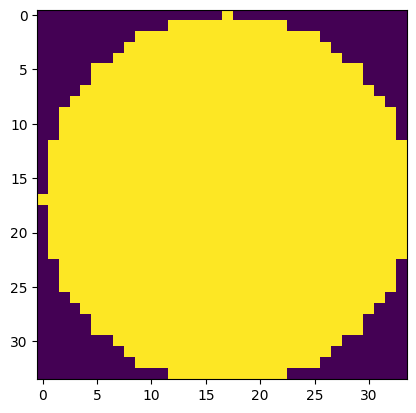

In [116]:



def convolve_stopgrid(radius): # radius in m

    # radius in px
    radius_px = m.floor(radius / (onepxlength * 1000))
    
    print(radius_px)

    circlegrid =  [[0 for i in range(radius_px * 2)] for j in range (radius_px * 2)]

    middle = GRIDSIZE / 2

    for x in range(radius_px * 2):
        for y in range(radius_px * 2):
            deltax = radius_px - x
            deltay = radius_px - y

            # calculate distance using pytagoras
            d = m.sqrt((deltax * deltax) + (deltay * deltay))

            if d <= radius_px:
                circlegrid[x][y] = 1
            else:
                circlegrid[x][y] = 0

    convolved_stopgrid = signal.fftconvolve(STOPSGRID, circlegrid, mode = "valid")

    return convolved_stopgrid

a = convolve_stopgrid(radius = 10000)

plt.imshow(circlegrid)
plt.show()

In [ ]:
# generate function people(distance)

SAMPLES = 20
START_RADIUS = 0.1 # in KM
STOP_RADIUS = 1 # in KM

radius_list = np.linspace(START_RADIUS, STOP_RADIUS, SAMPLES)

all_x = []
all_y = []

for i in tqdm(radius_list):
    all_y.append(analyze_grids(convolve_stopgrid(i)))
    all_x.append(i)

plt.plot(all_x, all_y)
plt.show()
    
    
